In [35]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [36]:
import os
os.chdir("/Users/bytedance/MLTrader-Research/")
import sys
sys.path.insert(0, ".")
import research.orderbook_strategies.utils.helper as helper
import research.orderbook_strategies.utils.stats as stats
import research.orderbook_strategies.utils.factor_analysis as factor_analysis
import research.orderbook_strategies.utils.factors as factors
from dask.diagnostics import ProgressBar
from imp import reload   
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import kurtosis, skew

In [37]:
from sklearn.decomposition import PCA

In [38]:
import warnings
import numpy as np
warnings.filterwarnings('ignore')

product_list = ["OPUSDT","BTCUSDT", "ETHUSDT", "APTUSDT", "1000PEPEUSDT"]

In [39]:
signal_list = ['kdj.k.32', 'kdj.k.128', 'range.pos.64', 'dbook.32', 'nr.64', 'rmi.32']
signal_weights = np.array([-1, -1, -1, 1, -1, -1])
signal_weights = list(signal_weights / np.sum(np.abs(signal_weights)))
all_signal = {}
pca_signal = {}

for product in product_list:
    sig = {}
    for signal in signal_list:
        sig[signal] = helper.auto_get_alldates_signal(signal, product)
    all_sig = pd.DataFrame(sig)
    print("corr matrix for {} {}".format(product, signal))
    print(all_sig.corr())
    print("--------------------")



corr matrix for OPUSDT rmi.32
              kdj.k.32  kdj.k.128  range.pos.64  dbook.32     nr.64    rmi.32
kdj.k.32      1.000000   0.391288      0.393697 -0.016564  0.659624  0.562641
kdj.k.128     0.391288   1.000000      0.948708  0.084620  0.783649  0.898054
range.pos.64  0.393697   0.948708      1.000000  0.090958  0.781523  0.878103
dbook.32     -0.016564   0.084620      0.090958  1.000000  0.037911  0.073159
nr.64         0.659624   0.783649      0.781523  0.037911  1.000000  0.834532
rmi.32        0.562641   0.898054      0.878103  0.073159  0.834532  1.000000
--------------------
corr matrix for BTCUSDT rmi.32
              kdj.k.32  kdj.k.128  range.pos.64  dbook.32     nr.64    rmi.32
kdj.k.32      1.000000   0.372899      0.385457  0.076311  0.600988  0.546051
kdj.k.128     0.372899   1.000000      0.926786  0.168516  0.765665  0.890871
range.pos.64  0.385457   0.926786      1.000000  0.161427  0.761872  0.862955
dbook.32      0.076311   0.168516      0.161427  1.000000  0

In [40]:
pcas = {}
for product in product_list:
    sig = {}
    for signal in signal_list:
        sig[signal] = helper.auto_get_alldates_signal(signal, product)
    all_sig = pd.DataFrame(sig)
    pca = PCA(n_components=1)
    pca.fit(all_sig[:len(all_sig)//2])
    print(pca.explained_variance_ratio_)
    pca_signal[product] = pca.transform(all_sig)
    pcas[product] = pca

[0.74064201]
[0.71532621]
[0.72111824]
[0.74055774]
[0.7375422]


In [41]:
def merge_signals(date_str, product, signals, weights=None, overwrite=False):
    new_name = "merge." + "_".join(signals)
    new_path = helper.SIGNAL_PATH / product / new_name / "{}.pkl".format(date_str)
    if new_path.exists() and not overwrite:
        return
    if weights is None or len(weights) != len(signals):
        weights = np.ones(len(signals))/len(signals)
    merge_signal = None
    for signal in signals:
        S = helper.get_signal(product, signal, date_str)
        if S is None:
            print(["warnings: get None for signal {} {} {}".format(signal, product, date_str)])
        if merge_signal is None:
            merge_signal = S * weights[0]
        else:
            merge_signal += S * weights[0]
    
    helper.save(merge_signal, new_path)
    
def merge_signals_pca(date_str, product, signals, pca, overwrite=False):
    new_name = "pca_merge." + "_".join(signals)
    new_path = helper.SIGNAL_PATH / product / new_name / "{}.pkl".format(date_str)
    if new_path.exists() and not overwrite:
        return
    
    merge_signal = []
    for signal in signals:
        S = helper.get_signal(product, signal, date_str)
        if S is None:
            print(["err: get None for signal {} {} {}".format(signal, product, date_str)])
            return None
        merge_signal.append(S)
    merge_signal = np.stack(merge_signal, axis=1)
    merge_signal[np.isnan(merge_signal)] = 0
    try:
        merge_signal = pca.transform(merge_signal)
    except Exception as e:
        
        print("error in {} {}".format(date_str, product))
        print(e)
    helper.save(merge_signal, new_path)
    
    

In [42]:
# merge_signal = []
# for signal in signal_list:
#     S = helper.get_signal('OPUSDT', signal, '2023-03-12')
#     merge_signal.append(S)
# merge_signal = np.stack(merge_signal, axis=1)

In [43]:
merge_signal = "merge." + "_".join(signal_list)
merge_pca_signal = "pca_merge." + "_".join(signal_list)

# 等权重合成因子

In [44]:
import functools
for product in product_list:
    date_strs = helper.get_dates_list(product)
    helper.parLapply(date_strs, merge_signals, product=product, weights=signal_weights, overwrite=True, signals=signal_list)

for product in product_list:
    all_dates = helper.get_dates_list(product)
    helper.parLapply([merge_signal], helper.par_generate_alldates_signal, date_list=all_dates, product=product, period=2048)
    

KeyboardInterrupt: 

In [ ]:
for product in product_list:
    spread = helper.product_info[product]["spread"]
    tranct_ratio = helper.product_info[product]["tranct.ratio"]
    all_dates = np.array(helper.get_dates_list(product))
    if product == "1000PEPEUSDT":
        split_str = "2023-06-10"
    else:
        split_str = "2023-04-01"
    all_dates = helper.get_dates_list(product)
    factor_analysis.evaluate_signal(merge_signal, all_dates, product,
                                    period=None,
                                    split_str=split_str,
                                    tranct=4e-4,
                                    max_spread=spread*1.8,
                                    atr_filter=0.01,  # 波动大于1%
                                    reverse=1,
                                    save_path="merged_signal_with_atr",
                                    overwrite=True)

In [46]:
results = factor_analysis.get_signal_performance_result(all_period_signal=[merge_signal], save_path="merged_signal_with_atr", product_list=product_list, min_avg_ret=1e-4, min_avg_trade_num=1, min_stra_threshold=1, directions=['trend'])

trend_res = results['trend.signal.stat']

display(trend_res.sort_values(by='trainSharpe', ascending=False))

,signal,reverse,num_good_product,good_product,trainSharpe,testSharpe,trainAvgDailyTradeNum,testAvgDailyTradeNum,avgTrainRet,avgTestRet,sum_good_strat
0,merge.kdj.k.32_kdj.k.128_range.pos.64_dbook.32...,1,2,"[OPUSDT, 1000PEPEUSDT]",2.095526,0.11538,5.257202,6.674806,0.006767,0.000201,6.0


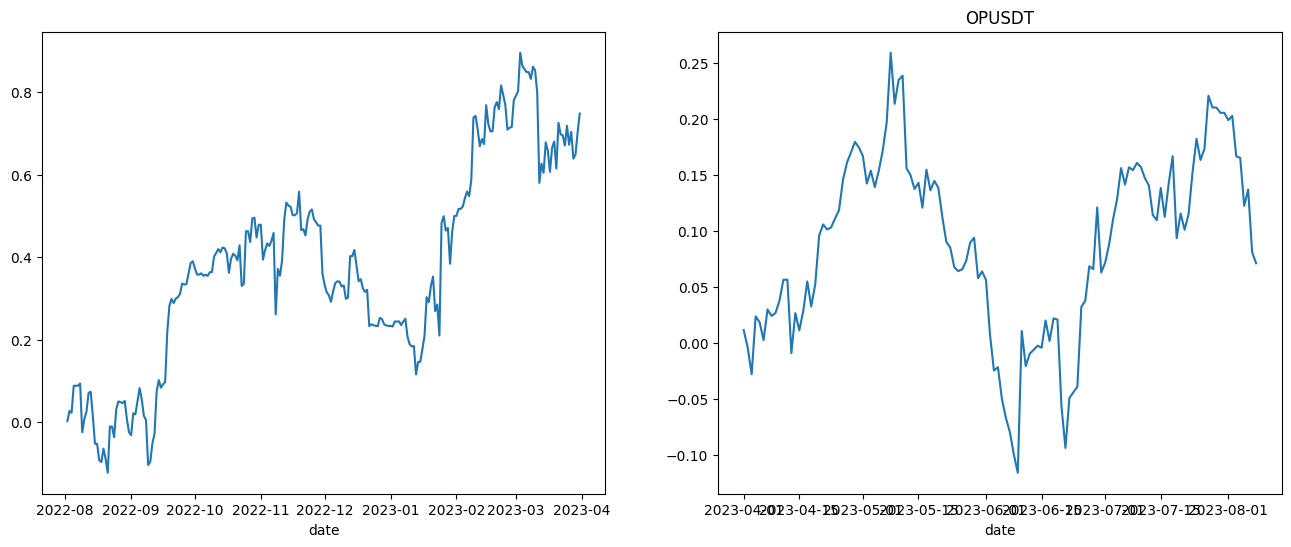

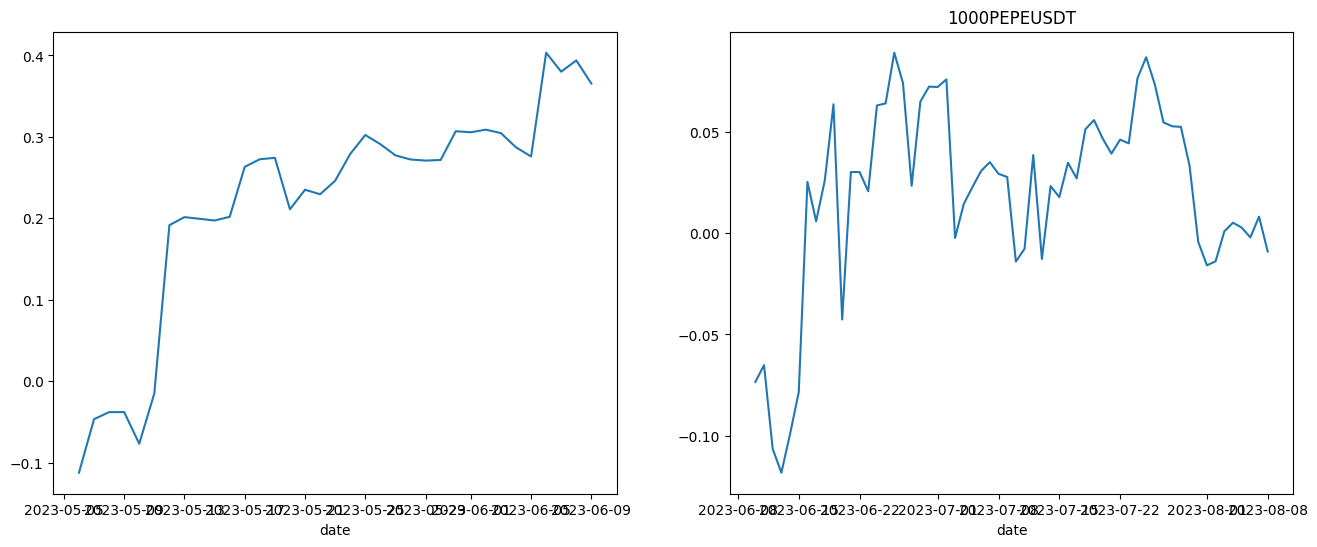

In [47]:
for product in product_list:
    if product in results['daily.ret'][merge_signal]["trend"]:
        f, axes = plt.subplots(1, 2, figsize=(16, 6))
        results['daily.ret'][merge_signal]["trend"][product]["train_pnl"].cumsum().plot(ax=axes[0])
        results['daily.ret'][merge_signal]["trend"][product]["test_pnl"].cumsum().plot(ax=axes[1])
        plt.title(product)
    

# PCA 合成因子

In [ ]:
import functools
for product in product_list:
    date_strs = helper.get_dates_list(product)
    helper.parLapply(date_strs, merge_signals_pca, product=product, overwrite=True, signals=signal_list, pca=pcas[product])
    
for product in product_list:
    all_dates = helper.get_dates_list(product)
    helper.parLapply([merge_pca_signal], helper.par_generate_alldates_signal, date_list=all_dates, product=product, period=2048)

In [48]:
for product in product_list:
    spread = helper.product_info[product]["spread"]
    tranct_ratio = helper.product_info[product]["tranct.ratio"]
    all_dates = np.array(helper.get_dates_list(product))
    if product == "1000PEPEUSDT":
        split_str = "2023-06-10"
    else:
        split_str = "2023-04-01"
    all_dates = helper.get_dates_list(product)
    factor_analysis.evaluate_signal(merge_pca_signal, all_dates, product,
                                    period=None,
                                    split_str=split_str,
                                    tranct=4e-4,
                                    max_spread=spread*1.8,
                                    atr_filter=0.01,  # 波动大于1%
                                    reverse=1,
                                    save_path="merged_signal_with_atr",
                                    overwrite=True)

evaludating signal trend OPUSDT pca_merge.kdj.k.32_kdj.k.128_range.pos.64_dbook.32_nr.64_rmi.32 done
evaludating signal trend BTCUSDT pca_merge.kdj.k.32_kdj.k.128_range.pos.64_dbook.32_nr.64_rmi.32 done
evaludating signal trend ETHUSDT pca_merge.kdj.k.32_kdj.k.128_range.pos.64_dbook.32_nr.64_rmi.32 done
evaludating signal trend APTUSDT pca_merge.kdj.k.32_kdj.k.128_range.pos.64_dbook.32_nr.64_rmi.32 done
evaludating signal trend 1000PEPEUSDT pca_merge.kdj.k.32_kdj.k.128_range.pos.64_dbook.32_nr.64_rmi.32 done


In [49]:
results = factor_analysis.get_signal_performance_result(all_period_signal=[merge_pca_signal], save_path="merged_signal_with_atr", product_list=product_list, min_avg_ret=1e-4, min_avg_trade_num=1, min_stra_threshold=1, directions=['trend'])

trend_res = results['trend.signal.stat']

display(trend_res.sort_values(by='trainSharpe', ascending=False))

,signal,reverse,num_good_product,good_product,trainSharpe,testSharpe,trainAvgDailyTradeNum,testAvgDailyTradeNum,avgTrainRet,avgTestRet,sum_good_strat
0,pca_merge.kdj.k.32_kdj.k.128_range.pos.64_dboo...,1,1,[1000PEPEUSDT],0.455176,-3.918209,10.614286,12.4,0.00297,-0.013424,2.0


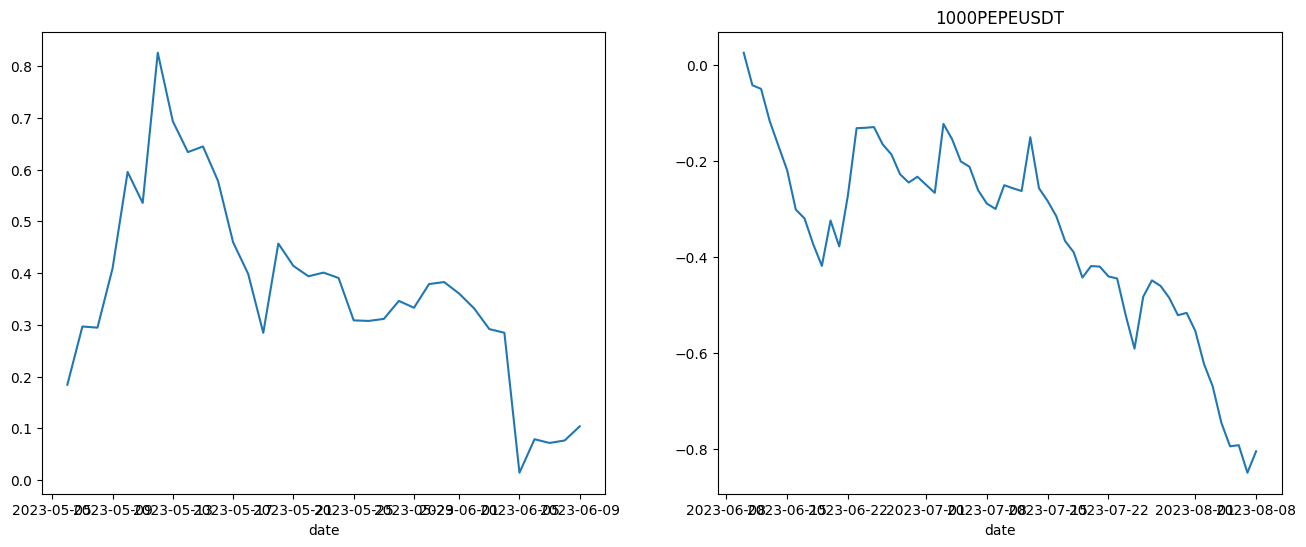

In [51]:
for product in product_list:
    if product in results['daily.ret'][merge_pca_signal]["trend"]:
        f, axes = plt.subplots(1, 2, figsize=(16, 6))
        results['daily.ret'][merge_pca_signal]["trend"][product]["train_pnl"].cumsum().plot(ax=axes[0])
        results['daily.ret'][merge_pca_signal]["trend"][product]["test_pnl"].cumsum().plot(ax=axes[1])
        plt.title(product)
    